In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import jax
import jax.numpy as jnp

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA
from nfmc_jax.DLA.posterior import TorchPosterior, JaxPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Gauss-mix

In [2]:
n = 100
mu1 = torch.ones(n) * (1.0 / 2.0)
mu2 = -mu1

stdev = 0.1
sigma = stdev ** 2 * torch.eye(n)
isigma = torch.linalg.inv(sigma)
dsigma = torch.linalg.det(sigma)

w1 = 0.1
w2 = 1 - w1

'''
def log_like(x):
    ll1 = -0.5 * (n * jnp.log(2 * np.pi) + 
                  jnp.matmul(jnp.transpose(x - mu1), jnp.matmul(isigma, x - mu1)))
    ll2 = -0.5 * (n * jnp.log(2 * np.pi) + 
                  jnp.matmul(jnp.transpose(x - mu2), jnp.matmul(isigma, x - mu2)))
    return jax.scipy.special.logsumexp(jnp.array([jnp.log(w1) + ll1, jnp.log(w2) + ll2]))

v_log_like = lambda x: jax.vmap(log_like)(x)

def log_prior(x):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=-100, scale=200))

v_log_prior = lambda x: jax.vmap(log_prior)(x)
'''

def log_like(x):
    mix = torch.distributions.Categorical(torch.tensor([w1, w2]))
    comp = torch.distributions.Independent(torch.distributions.Normal(
             torch.cat([mu1.reshape(n, 1), mu2.reshape(n, 1)], dim=1).T, stdev * torch.ones((2, n))), 1)
    gmm = torch.distributions.MixtureSameFamily(mix, comp)
    return gmm.log_prob(x)
                                           

def log_prior(x):
    return torch.distributions.MultivariateNormal(loc=torch.zeros(x.shape[1]),
                                                  covariance_matrix=1000 ** 2 * torch.eye(n)).log_prob(x)

def prior_rvs(N):
    return torch.distributions.Uniform(low=-2, high=2).sample((N, n))

posterior = TorchPosterior(log_likelihood = lambda x: log_like(x),
                           log_prior = lambda x: log_prior(x))

#posterior = JaxPosterior(log_likelihood = lambda x: v_log_like(x),
#                         log_prior = lambda x: v_log_prior(x))

initial_samples = prior_rvs(2000)
print(initial_samples.shape)

mix_idx = np.random.multinomial(2000, pvals=np.array([w1, w2]))
n1_samples = n_mvn.rvs(mean=mu1, cov=sigma, size=mix_idx[0])
n2_samples = n_mvn.rvs(mean=mu2, cov=sigma, size=mix_idx[1])
truth_samples = np.concatenate((n1_samples, n2_samples))


torch.Size([2000, 100])


In [3]:
#np.savetxt('./fiducial_samples/gauss_mix_init_2000.txt', initial_samples)
initial_samples = np.loadtxt('./fiducial_samples/gauss_mix_init_2000.txt')
initial_samples = torch.tensor(initial_samples, dtype=torch.float32)

torch.Size([100, 2])


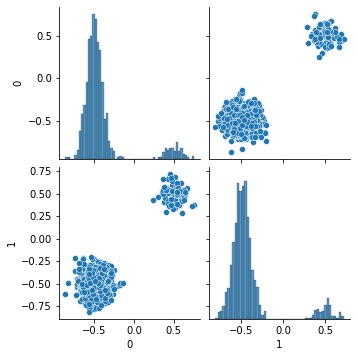

In [4]:
print(torch.cat([mu1.reshape(100, 1), mu2.reshape(100, 1)], dim=1).shape)

mix = torch.distributions.Categorical(torch.tensor([w1, w2]))
comp = torch.distributions.Independent(torch.distributions.Normal(
             torch.cat([mu1.reshape(n, 1), mu2.reshape(n, 1)], dim=1).T, stdev * torch.ones((2, n))), 1)
gmm = torch.distributions.MixtureSameFamily(mix, comp)
gmm_x = gmm.sample((1000,))

sns.pairplot(pd.DataFrame(gmm_x[:, 0:2]))

In [80]:
# Note - check about passing validation data to this.

burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                           val_frac=0.3,
                           iteration=None,
                           bounds=None,
                           alpha=(0.0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=True,
                           MSWD_max_iter=200)

In [82]:
flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.3,
                           iteration=None,
                           bounds=None,
                           alpha=(0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=True,
                           MSWD_max_iter=None)

In [83]:
dlmc = LatentDLA(
    interface=flow_interface,
    burnin_interface=flow_interface,
    posterior=posterior,
)

xf = dlmc.run(initial_samples,
              step=1.0,
              burnin_optimizer='line_search',
              optimizer='line_search',
              optim_scheduler='identity',
              exp_decay_rate=0.99,
              cos_T_max=100,
              cos_lr_min=0.0,
              burnin_optim_steps=1,
              optim_steps=1,
              atol=1e-15,
              max_burnin=100,
              burnin_thresh=10.0,
              num_upsample=0,
              max_iterations=20,
         latent=True,
         IMHstep=1,
         CMHstep=0,
         CMHscale=0.1,
         ULMstep=0,
         stochastic_calibration=False,
         taylor_zeta=True,
         use_tqdm=True,
         post_ulm_steps=0,
         post_ulm_batch=0,
         animate_kwargs=dict(
             dpi=200),
         train_kwargs={'val_frac': 0.2},
         underdamped_kwargs={'step_size':1.0e-2, 'gamma': 2.0}
        )

  0%|                                                   | 0/120 [00:00<?, ?it/s]

Virial = 3226.790283203125
<sum_x_virial> = 3226.790283203125


[Stage 0] Beta: 1.0:   1%|    | 1/120 [00:03<07:12,  3.64s/it, accept_IMH=0.028]

<step_counter> = 1.0609999895095825
Virial = 3119.2197265625
<sum_x_virial> = 3119.2197265625


[Stage 0] Beta: 1.0:   2%|    | 2/120 [00:08<08:03,  4.10s/it, accept_IMH=0.207]

<step_counter> = 1.7115000486373901
Virial = 2213.702392578125
<sum_x_virial> = 2213.702392578125


[Stage 0] Beta: 1.0:   2%|    | 3/120 [00:12<08:17,  4.25s/it, accept_IMH=0.111]

<step_counter> = 1.503999948501587
Virial = 1755.4371337890625
<sum_x_virial> = 1755.4371337890625


[Stage 0] Beta: 1.0:   3%|▏   | 4/120 [00:16<08:22,  4.33s/it, accept_IMH=0.111]

<step_counter> = 1.6614999771118164
Virial = 1592.195556640625
<sum_x_virial> = 1592.195556640625


[Stage 0] Beta: 1.0:   4%|▏    | 5/120 [00:21<08:29,  4.43s/it, accept_IMH=0.11]

<step_counter> = 1.2135000228881836
Virial = 1430.115966796875
<sum_x_virial> = 1430.115966796875


[Stage 0] Beta: 1.0:   5%|▏  | 6/120 [00:26<08:26,  4.44s/it, accept_IMH=0.0735]

<step_counter> = 1.1480000019073486
Virial = 1235.3759765625
<sum_x_virial> = 1235.3759765625


[Stage 0] Beta: 1.0:   5%|▏  | 6/120 [00:31<08:26,  4.44s/it, accept_IMH=0.0465]

<step_counter> = 1.1579999923706055


[Stage 0] Beta: 1.0:   6%|▏  | 7/120 [00:31<08:56,  4.75s/it, accept_IMH=0.0465]

Virial = 1056.4447021484375
<sum_x_virial> = 1056.4447021484375


[Stage 0] Beta: 1.0:   6%|▏   | 7/120 [00:36<08:56,  4.75s/it, accept_IMH=0.049]

<step_counter> = 1.0789999961853027


[Stage 0] Beta: 1.0:   7%|▎   | 8/120 [00:36<09:06,  4.88s/it, accept_IMH=0.049]

Virial = 876.971923828125
Reached virial threshold during burnin.
<sum_x_virial> = 876.971923828125
delta_virial = 0.0


[Stage 0] Beta: 1.0:   7%|▎   | 8/120 [00:41<09:06,  4.88s/it, accept_IMH=0.044]

<step_counter> = 1.0985000133514404


[Stage 0] Beta: 1.0:   8%|▎   | 9/120 [00:41<09:08,  4.94s/it, accept_IMH=0.044]

<sum_x_virial> = 733.377685546875
delta_virial = 0.1637386977672577


[Stage 0] Beta: 1.0:   8%|▏ | 10/120 [00:45<08:37,  4.70s/it, accept_IMH=0.0595]

<step_counter> = 1.0460000038146973
<sum_x_virial> = 584.589111328125
delta_virial = 0.20288124680519104


[Stage 0] Beta: 1.0:   9%|▎  | 11/120 [00:49<08:13,  4.53s/it, accept_IMH=0.075]

<step_counter> = 1.024999976158142
<sum_x_virial> = 475.3852844238281
delta_virial = 0.1868044137954712


[Stage 0] Beta: 1.0:  10%|▏ | 12/120 [00:54<07:56,  4.42s/it, accept_IMH=0.0635]

<step_counter> = 1.0425000190734863
<sum_x_virial> = 384.9567565917969
delta_virial = 0.19022154808044434


[Stage 0] Beta: 1.0:  11%|▏ | 13/120 [00:57<07:21,  4.13s/it, accept_IMH=0.0655]

<step_counter> = 1.058500051498413
<sum_x_virial> = 322.8994445800781
delta_virial = 0.1612059324979782


[Stage 0] Beta: 1.0:  12%|▏ | 14/120 [01:01<06:56,  3.93s/it, accept_IMH=0.0555]

<step_counter> = 1.0889999866485596
<sum_x_virial> = 272.9920349121094
delta_virial = 0.15456022322177887


[Stage 0] Beta: 1.0:  12%|▎ | 15/120 [01:04<06:38,  3.79s/it, accept_IMH=0.0705]

<step_counter> = 1.0609999895095825
<sum_x_virial> = 228.1207733154297
delta_virial = 0.1643683910369873


[Stage 0] Beta: 1.0:  13%|▎ | 16/120 [01:07<06:23,  3.69s/it, accept_IMH=0.0695]

<step_counter> = 1.090000033378601
<sum_x_virial> = 198.35595703125
delta_virial = 0.13047832250595093


[Stage 0] Beta: 1.0:  13%|▎ | 16/120 [01:12<06:23,  3.69s/it, accept_IMH=0.0795]

<step_counter> = 1.065000057220459


[Stage 0] Beta: 1.0:  14%|▎ | 17/120 [01:12<06:54,  4.02s/it, accept_IMH=0.0795]

<sum_x_virial> = 173.98104858398438
delta_virial = 0.12288468331098557


[Stage 0] Beta: 1.0:  15%|▍  | 18/120 [01:16<06:33,  3.86s/it, accept_IMH=0.066]

<step_counter> = 1.0750000476837158
<sum_x_virial> = 154.6904754638672
delta_virial = 0.11087743937969208


[Stage 0] Beta: 1.0:  16%|▎ | 19/120 [01:19<06:18,  3.74s/it, accept_IMH=0.0815]

<step_counter> = 1.0870000123977661
<sum_x_virial> = 142.9302520751953
delta_virial = 0.07602422684431076


[Stage 0] Beta: 1.0:  17%|▌  | 20/120 [01:23<06:07,  3.68s/it, accept_IMH=0.081]

<step_counter> = 1.1154999732971191
<sum_x_virial> = 133.57400512695312
delta_virial = 0.06546022742986679


[Stage 0] Beta: 1.0:  18%|▌  | 21/120 [01:26<05:59,  3.63s/it, accept_IMH=0.059]

<step_counter> = 1.0989999771118164
<sum_x_virial> = 129.7706756591797
delta_virial = 0.02847357466816902


[Stage 0] Beta: 1.0:  18%|▎ | 22/120 [01:30<05:54,  3.62s/it, accept_IMH=0.0575]

<step_counter> = 1.0820000171661377
<sum_x_virial> = 125.58443450927734
delta_virial = 0.032258760184049606


[Stage 0] Beta: 1.0:  19%|▌  | 23/120 [01:33<05:48,  3.60s/it, accept_IMH=0.054]

<step_counter> = 1.1165000200271606
<sum_x_virial> = 122.62539672851562
delta_virial = 0.02356213890016079


[Stage 0] Beta: 1.0:  20%|▍ | 24/120 [01:37<05:41,  3.56s/it, accept_IMH=0.0655]

<step_counter> = 1.0789999961853027
<sum_x_virial> = 121.03773498535156
delta_virial = 0.01294725015759468


[Stage 0] Beta: 1.0:  21%|▍ | 25/120 [01:40<05:36,  3.54s/it, accept_IMH=0.0525]

<step_counter> = 1.0785000324249268
<sum_x_virial> = 119.75623321533203
delta_virial = 0.010587621480226517


[Stage 0] Beta: 1.0:  22%|▋  | 26/120 [01:44<05:30,  3.52s/it, accept_IMH=0.059]

<step_counter> = 1.0740000009536743
<sum_x_virial> = 119.02554321289062
delta_virial = 0.006101477891206741


[Stage 0] Beta: 1.0:  22%|▍ | 27/120 [01:47<05:26,  3.52s/it, accept_IMH=0.0615]

<step_counter> = 1.0789999961853027
<sum_x_virial> = 116.84906768798828
delta_virial = 0.018285784870386124


[Stage 0] Beta: 1.0:  23%|▍ | 28/120 [01:51<05:23,  3.51s/it, accept_IMH=0.0515]

<step_counter> = 1.0820000171661377
<sum_x_virial> = 115.83073425292969
delta_virial = 0.008714946918189526


[Stage 0] Beta: 1.0:  24%|▋  | 29/120 [01:54<05:18,  3.50s/it, accept_IMH=0.077]

<step_counter> = 1.0724999904632568
<sum_x_virial> = 114.80580139160156
delta_virial = 0.008848539553582668


[Stage 0] Beta: 1.0:  25%|▌ | 30/120 [01:58<05:54,  3.94s/it, accept_IMH=0.0695]


<step_counter> = 1.0729999542236328
Reached maximum number of post-burnin DLMC iterations.


0it [00:00, ?it/s]


In [84]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=5):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=0.3)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=0.3)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

     labels     $x_0$     $x_1$
0         q -0.591458 -0.454918
1         q -0.285211 -0.569677
2         q -0.383742 -0.353601
3         q -0.566423 -0.627214
4         q -0.528250 -0.382777
...     ...       ...       ...
3995      T -0.580872 -0.576714
3996      T -0.397445 -0.442417
3997      T -0.544360 -0.284227
3998      T -0.487654 -0.608379
3999      T -0.544587 -0.614653

[4000 rows x 3 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

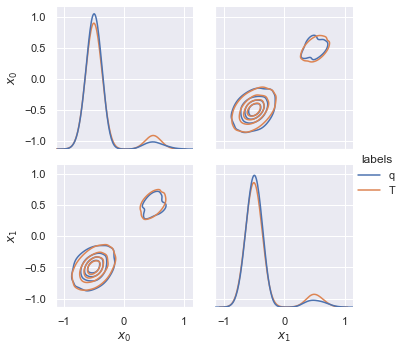

In [85]:
sns_pairplot(xf[0][:, 0:2], np.ones(len(xf[0])), truth_samples[:, 0:2])

     labels     $x_0$     $x_1$
0         q -0.462705 -0.465435
1         q  0.376471  0.635199
2         q -0.362328 -0.641013
3         q -0.588857 -0.423060
4         q -0.468445 -0.454436
...     ...       ...       ...
3995      T -0.580872 -0.576714
3996      T -0.397445 -0.442417
3997      T -0.544360 -0.284227
3998      T -0.487654 -0.608379
3999      T -0.544587 -0.614653

[4000 rows x 3 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

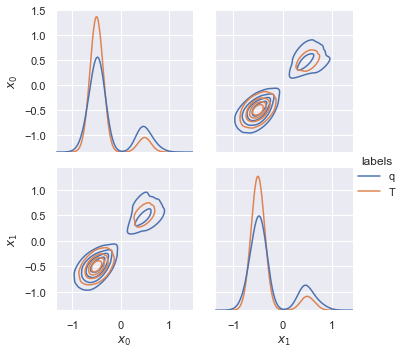

In [63]:
xi = xf[1]
x = xi['20']
sns_pairplot(x[:, 0:2], np.ones(len(x)), truth_samples[:, 0:2])

     labels     $x_0$     $x_1$
0         q  0.509840  0.381517
1         q -0.364215 -0.515069
2         q  0.472440  0.498714
3         q  0.361308  0.483120
4         q  0.480827  0.625046
...     ...       ...       ...
3995      T  0.445641  0.595691
3996      T  0.399983  0.584025
3997      T  0.395819  0.421095
3998      T  0.524286  0.429244
3999      T -0.352425 -0.386186

[4000 rows x 3 columns]


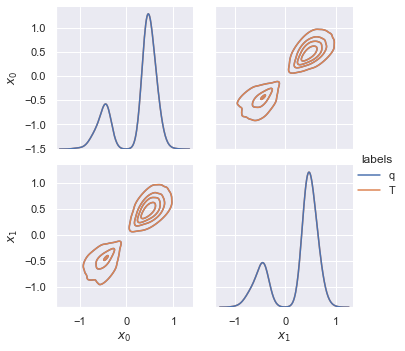

In [42]:
xi = xf[1]
sns_pairplot(xi['23'][:, 0:2], np.ones(len(x)), xi['23'][:, 0:2])

     labels     $x_0$     $x_1$
0         q -0.476413 -0.520007
1         q -0.311077 -0.569856
2         q -0.593345 -0.515004
3         q -0.632095 -0.554290
4         q -0.449761 -0.503506
...     ...       ...       ...
3995      T -0.452464 -0.435272
3996      T -0.669112 -0.395251
3997      T -0.635188 -0.518629
3998      T -0.678314 -0.353220
3999      T -0.580950 -0.354116

[4000 rows x 3 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

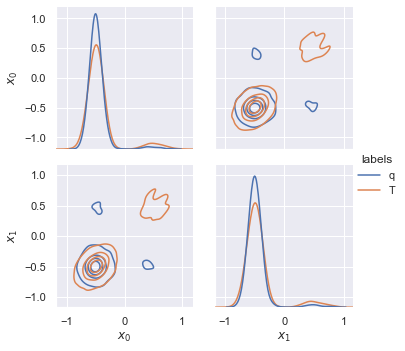

In [51]:
q = xf[2]
qx = q['28']
x = xi['28']
sns_pairplot(qx[:, 0:2], np.ones(len(qx)), x[:, 0:2])

Save output for posterity

In [49]:
out_dir = '/Users/richardgrumitt/Documents/berkeley/nfmc_jax_tests/dlmc_grad_experiments/gauss_mix/'

np.savetxt(f'{out_dir}final_x_2000N_iter29.txt', xf[0])

with open(f'{out_dir}x_iters.pkl', 'wb') as f:
    pickle.dump(xf[1], f)
    f.close()
    
with open(f'{out_dir}qx_iters.pkl', 'wb') as f:
    pickle.dump(xf[2], f)
    f.close()
    
with open(f'{out_dir}var_iters.pkl', 'wb') as f:
    pickle.dump(xf[3], f)
    f.close()
    
with open(f'{out_dir}mean_iters.pkl', 'wb') as f:
    pickle.dump(xf[4], f)
    f.close()

# Test post-MH

In [16]:
logp = lambda x: log_like(x) + log_prior(x)

def IMH(x, nf_interface):
    logp_old = logp(x)
    logq_old = nf_interface.logq(x)

    sample, logq_new = nf_interface.sample_with_logq(len(x))
    logp_new = logp(sample)

    logr = logp_new + logq_old - logp_old - logq_new

    accept = torch.log(torch.rand(len(x))) < logr
    x[accept] = sample[accept]
    return x, accept

In [87]:
nf_interface = SINFInterface()
nf_interface.create_flow(x=xf[0],
                         val_frac=0.2,
                         iteration=None,
                         bounds=None,
                         alpha=None,
                         NBfirstlayer=True,
                         verbose=False,
                         M=None,
                         Whiten=False,
                         Whiten_with_weights=False,
                         Whiten_reg='NERCOME',
                         maxknot=True,
                         MSWD_max_iter=100)

     labels     $x_0$     $x_1$
0         q  0.569444  0.630901
1         q  0.580687  0.434805
2         q  0.484834  0.364831
3         q -0.209745 -0.244009
4         q -0.263146 -0.113375
...     ...       ...       ...
4995      T  0.615184  0.537315
4996      T -0.453388 -0.504110
4997      T  0.343167  0.426556
4998      T  0.478767  0.482332
4999      T -0.508034 -0.427467

[5000 rows x 3 columns]


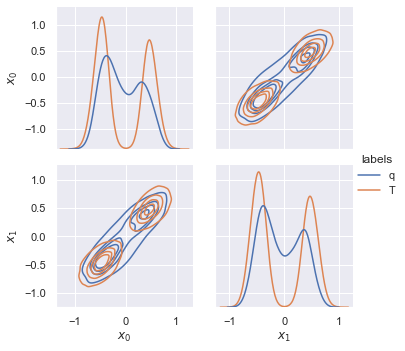

In [88]:
qf = nf_interface.sample(1000)
sns_pairplot(qf[:, 0:2], np.ones(len(qf)), xi['36'][:, 0:2])

In [91]:
nf_interface.flow

SINF(
  (layer): ModuleList(
    (0): SlicedTransport(
      (transform1D): RQspline()
    )
    (1): SlicedTransport(
      (transform1D): RQspline()
    )
    (2): SlicedTransport(
      (transform1D): RQspline()
    )
    (3): SlicedTransport(
      (transform1D): RQspline()
    )
    (4): SlicedTransport(
      (transform1D): RQspline()
    )
    (5): SlicedTransport(
      (transform1D): RQspline()
    )
    (6): SlicedTransport(
      (transform1D): RQspline()
    )
    (7): SlicedTransport(
      (transform1D): RQspline()
    )
    (8): SlicedTransport(
      (transform1D): RQspline()
    )
    (9): SlicedTransport(
      (transform1D): RQspline()
    )
    (10): SlicedTransport(
      (transform1D): RQspline()
    )
    (11): SlicedTransport(
      (transform1D): RQspline()
    )
    (12): SlicedTransport(
      (transform1D): RQspline()
    )
    (13): SlicedTransport(
      (transform1D): RQspline()
    )
    (14): SlicedTransport(
      (transform1D): RQspline()
    )
    (1

Acceptance = 0.11725
Acceptance = 0.11125
Acceptance = 0.10425
Acceptance = 0.09825
Acceptance = 0.087
     labels     $x_0$     $x_1$
0         q  0.486001  0.391170
1         q  0.452779  0.381230
2         q  0.646556  0.488115
3         q -0.555677 -0.472782
4         q  0.453008  0.519290
...     ...       ...       ...
7995      T  0.615184  0.537315
7996      T -0.453388 -0.504110
7997      T  0.343167  0.426556
7998      T  0.478767  0.482332
7999      T -0.508034 -0.427467

[8000 rows x 3 columns]


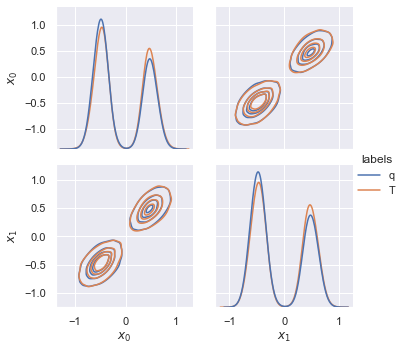

In [89]:
from copy import deepcopy
xmh = deepcopy(xi['36'])
for i in range(5):
    xmh, acc = IMH(xmh, nf_interface)
    acc_rate = len(acc[acc == True]) / len(acc)
    print(f'Acceptance = {acc_rate}')
sns_pairplot(xmh[:, 0:2], np.ones(len(xmh)), xi['36'][:, 0:2])

     labels     $x_0$     $x_1$
0         q  0.486001  0.391170
1         q  0.452779  0.381230
2         q  0.646556  0.488115
3         q -0.555677 -0.472782
4         q  0.453008  0.519290
...     ...       ...       ...
5995      T -0.580872 -0.576714
5996      T -0.397445 -0.442417
5997      T -0.544360 -0.284227
5998      T -0.487654 -0.608379
5999      T -0.544587 -0.614653

[6000 rows x 3 columns]


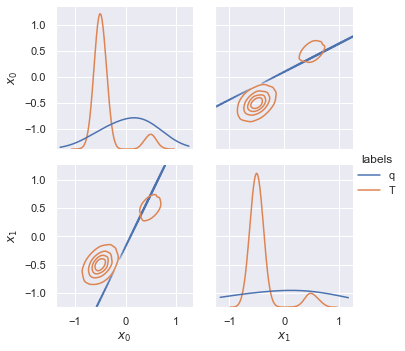

In [90]:
logqf = nf_interface.logq(xf[0])
logpf = logp(xf[0])
logw = logqf - logpf
logw -= torch.logsumexp(logw, dim=0)
sns_pairplot(xf[0][:, 0:2], torch.exp(logw), truth_samples[:, 0:2])

In [49]:
def log_likelihood_gradient(x):

    x.requires_grad_(True)
    value = log_like(x)
    grad = torch.autograd.grad(value.sum(), x, create_graph=True)[0]
    x.requires_grad_(False)
    return grad

def log_prior_gradient(x):

    x.requires_grad_(True)
    value = log_prior(x)
    grad = torch.autograd.grad(value.sum(), x, create_graph=True)[0]
    x.requires_grad_(False)
    return grad

def logp_gradient(x):
    
    return log_likelihood_gradient(x) + log_prior_gradient(x)

In [73]:
def latent_hmc(x: torch.Tensor,
               nf_interface,
               n_steps: int,
               hmc_step_size: float,
               num_leapfrog: int = 10):

    logp_old = logp(x)

    z, logj_forward_old = nf_interface.forward_with_logj(x)
    z = z.reshape(len(z), -1)
    print(f'z.shape = {z.shape}')
    hmc_step = 0
    mass = 1.0 / torch.var(z, dim=0)

    acceptance_rate = []
    replaced = torch.zeros(len(x), dtype=torch.bool, device=x.device)
    for i in range(n_steps):
        hmc_step += 1

        current_logp = logp_old - logj_forward_old

        momenta = torch.randn_like(z)
        current_hamiltonian = 0.5 * torch.sum(momenta ** 2, dim=1) - current_logp
        z_new = deepcopy(z)
        x_new = deepcopy(x)

        for leap in range(num_leapfrog):
            grad_x_logp = logp_gradient(x_new)
            grad_z_logp = nf_interface.grad_z_logp(z_new, grad_wrt_x=grad_x_logp) + nf_interface.grad_z_logj(
                z_new)
            print(f'||grad_z_logp|| = {torch.linalg.norm(grad_z_logp, dim=1)}')
            momenta = momenta + 0.5 * hmc_step_size * grad_z_logp

            z_new = z_new + hmc_step_size * momenta
            x_new = nf_interface.inverse(z_new)

            grad_x_logp = logp_gradient(x_new)
            grad_z_logp = nf_interface.grad_z_logp(z_new, grad_wrt_x=grad_x_logp) + nf_interface.grad_z_logj(
                z_new)
            momenta = momenta + 0.5 * hmc_step_size * grad_z_logp

        logp_new = logp(x)
        logj_backward_new = nf_interface.logj_backward(z_new)
        new_hamiltonian = 0.5 * torch.sum(momenta ** 2, dim=1) - logp_new - logj_backward_new

        logr = current_hamiltonian - new_hamiltonian
        accept = torch.log(torch.rand(len(x))) < logr
        acceptance_rate.append(torch.sum(accept).item() / len(x))
        replaced = replaced + accept

        x[accept] = x_new[accept]
        logp_old[accept] = logp_new[accept]
        z[accept] = z_new[accept]
        logj_forward_old[accept] = -logj_backward_new[accept]

    return x, acceptance_rate, torch.sum(replaced).item() / len(x)

In [75]:
x_before = deepcopy(xf[0])
xhmc, acc_rate, tot_acc_rate = latent_hmc(xf[0], nf_interface, 50, 0.01, 5)

z.shape = torch.Size([4000, 100])
||grad_z_logp|| = tensor([136.8425,  40.1845,  26.7935,  ...,  44.9676,  39.6928,  38.1953])
||grad_z_logp|| = tensor([110.7261,  38.9761,  26.8872,  ...,  42.4331,  38.8253,  38.3930])
||grad_z_logp|| = tensor([89.9574, 37.4082, 26.7320,  ..., 36.9029, 37.1566, 37.6213])
||grad_z_logp|| = tensor([75.4826, 35.6515, 26.8305,  ..., 35.6383, 35.5078, 36.9086])
||grad_z_logp|| = tensor([61.5818, 33.8553, 27.1924,  ..., 28.6067, 33.7898, 36.2241])
||grad_z_logp|| = tensor([136.8425,  40.1845,  26.7935,  ...,  44.9676,  32.0828,  38.1953])
||grad_z_logp|| = tensor([113.9621,  38.1506,  26.5861,  ...,  44.5012,  26.3823,  38.7335])
||grad_z_logp|| = tensor([90.7997, 35.9867, 26.3847,  ..., 43.4636, 26.4488, 38.9328])
||grad_z_logp|| = tensor([73.9238, 33.8136, 25.9580,  ..., 41.8379, 26.5583, 39.2455])
||grad_z_logp|| = tensor([62.2559, 31.7264, 25.6775,  ..., 39.9431, 27.1169, 39.5662])
||grad_z_logp|| = tensor([136.8425,  40.1845,  26.7935,  ...,  44.9676, 

||grad_z_logp|| = tensor([136.8425,  63.3388,  30.3714,  ..., 103.6135,  56.0498,  46.7302])
||grad_z_logp|| = tensor([128.2962,  61.3488,  29.8398,  ..., 112.5492,  49.4496,  46.0327])
||grad_z_logp|| = tensor([108.7586,  56.5000,  28.6440,  ..., 100.2820,  43.3673,  45.6732])
||grad_z_logp|| = tensor([90.0923, 51.9160, 27.6836,  ..., 96.0033, 42.4679, 45.1208])
||grad_z_logp|| = tensor([122.7118,  46.4230,  27.0699,  ..., 127.0013,  39.6749,  44.1917])
||grad_z_logp|| = tensor([136.8425,  63.3388,  30.3714,  ..., 103.6135,  56.0498,  46.7302])
||grad_z_logp|| = tensor([147.1286,  60.7479,  30.5211,  ...,  90.0909,  55.1396,  45.4197])
||grad_z_logp|| = tensor([124.1220,  56.3359,  30.5300,  ...,  69.6643,  51.7043,  44.0944])
||grad_z_logp|| = tensor([96.9345, 51.9276, 30.3991,  ..., 55.3968, 46.7732, 41.1066])
||grad_z_logp|| = tensor([74.6578, 47.3343, 30.2995,  ..., 49.6033, 41.8047, 40.2359])
||grad_z_logp|| = tensor([136.8425,  63.3388,  30.5780,  ..., 103.6135,  56.0498,  46.73

||grad_z_logp|| = tensor([136.8425,  63.3388,  43.7655,  ..., 103.6135,  65.6500,  50.2343])
||grad_z_logp|| = tensor([119.1184,  64.6673,  43.7743,  ...,  92.3067,  51.4418,  49.6675])
||grad_z_logp|| = tensor([96.5518, 63.9239, 43.6855,  ..., 75.8349, 41.8719, 49.0486])
||grad_z_logp|| = tensor([87.8048, 61.0701, 42.9883,  ..., 65.5438, 35.6367, 48.7977])
||grad_z_logp|| = tensor([81.1002, 56.3760, 36.2700,  ..., 60.2887, 25.5290, 48.6268])
||grad_z_logp|| = tensor([136.8425,  63.3388,  36.7659,  ..., 103.6135,  65.6500,  50.2343])
||grad_z_logp|| = tensor([124.8429,  60.3777,  36.4570,  ..., 122.1274,  64.5931,  49.6051])
||grad_z_logp|| = tensor([101.1375,  55.8828,  36.0502,  ..., 110.2892,  58.3431,  49.0490])
||grad_z_logp|| = tensor([87.2495, 50.9846, 39.3001,  ..., 84.3160, 50.2095, 48.2467])
||grad_z_logp|| = tensor([74.1709, 46.4299, 39.1733,  ..., 65.2435, 43.1230, 47.2717])
||grad_z_logp|| = tensor([136.8425,  63.3388,  36.7659,  ..., 103.6135,  65.6500,  50.2343])
||grad_

In [76]:
print(acc_rate)

[0.304, 0.28175, 0.286, 0.27475, 0.255, 0.2565, 0.24325, 0.24025, 0.2365, 0.23, 0.22675, 0.22525, 0.21925, 0.20475, 0.2075, 0.20675, 0.19775, 0.204, 0.1965, 0.204, 0.1895, 0.19675, 0.183, 0.19325, 0.186, 0.1915, 0.1775, 0.187, 0.1825, 0.1835, 0.17075, 0.16925, 0.16225, 0.1645, 0.1595, 0.15925, 0.16075, 0.1495, 0.15125, 0.152, 0.1425, 0.1505, 0.14825, 0.14225, 0.133, 0.13425, 0.13675, 0.13575, 0.13975, 0.13125]


     labels     $x_0$     $x_1$
0         q  0.486001  0.391170
1         q  0.452779  0.381230
2         q  0.646556  0.488115
3         q -0.555677 -0.472782
4         q  0.453008  0.519290
...     ...       ...       ...
7995      T  0.615184  0.537315
7996      T -0.412278 -0.507067
7997      T  0.353685  0.430676
7998      T  0.478489  0.470895
7999      T -0.510770 -0.437721

[8000 rows x 3 columns]


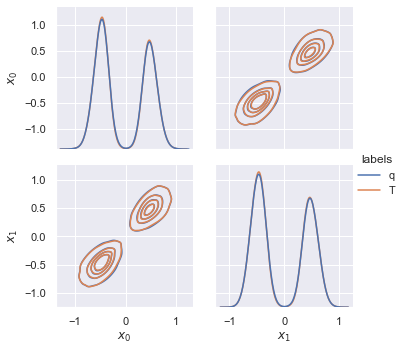

In [77]:
sns_pairplot(xhmc[:, 0:2], np.ones(len(xhmc)), x_before[:, 0:2])

In [79]:
xhmc[:, 0:2] - x_before[:, 0:2]

tensor([[ 0.0000,  0.0000],
        [-0.0045,  0.0013],
        [-0.0208,  0.0534],
        ...,
        [-0.0105, -0.0041],
        [ 0.0003,  0.0114],
        [ 0.0027,  0.0103]])

# Debug

In [95]:
def generate_alum_noise(ndim: int,
                        step_size: np.float64,
                        gamma: np.float64,
                        alpha: torch.Tensor):
    # Generate the noise terms for ALUM version of underdamped Langevin.
    e_xh = torch.zeros((alpha.shape[0], ndim))
    e_vh = torch.zeros((alpha.shape[0], ndim))
    e_xah = torch.zeros((alpha.shape[0], ndim))
    
    gamma = torch.tensor(gamma, dtype=torch.float64)
    step_size = torch.tensor(step_size, dtype=torch.float64)

    for i, a in enumerate(alpha):
        cov_xtxt = (2.0 * gamma * step_size - 3.0 + 4.0 * torch.exp(-gamma * step_size) - torch.exp(
            -2.0 * gamma * step_size)) / gamma ** 2
        cov_xtvt = (4.0 * torch.sinh(gamma * step_size / 2.0) ** 2 * torch.exp(-gamma * step_size)) / gamma
        cov_vtvt = (1.0 - torch.exp(-2.0 * gamma * step_size))
        cov_xtxat = (2.0 * a * gamma * step_size - 2.0 - 4.0 * torch.exp(-gamma * step_size) * torch.sinh(
            a * gamma * step_size / 2.0) ** 2 + 2.0 * torch.exp(-a * gamma * step_size)) / gamma ** 2
        cov_vtxat = 4.0 * torch.sinh(a * gamma * step_size / 2.0) ** 2 * torch.exp(
            -gamma * step_size) / gamma
        cov_xatxat = (2.0 * a * gamma * step_size - 3.0 + 4.0 * torch.exp(-a * gamma * step_size) - torch.exp(
            - 2.0 * a * gamma * step_size)) / gamma ** 2
        print(f'cov_xtxt = {cov_xtxt}')
        print(f'cov_xtvt = {cov_xtvt}')
        print(f'cov_vtvt = {cov_vtvt}')
        print(f'cov_xtxat = {cov_xtxat}')
        print(f'cov_vtxat = {cov_vtxat}')
        print(f'cov_xatxat = {cov_xatxat}')
        
        block_row1 = torch.cat([cov_xtxt * torch.eye(ndim), cov_xtvt * torch.eye(ndim), cov_xtxat * torch.eye(ndim)], 
                               dim=1)
        block_row2 = torch.cat([cov_xtvt * torch.eye(ndim), cov_vtvt * torch.eye(ndim), cov_vtxat * torch.eye(ndim)], 
                               dim=1)
        block_row3 = torch.cat([cov_xtxat * torch.eye(ndim), cov_vtxat * torch.eye(ndim), cov_xatxat * torch.eye(ndim)], 
                               dim=1)
        cov_alum = torch.cat([block_row1, block_row2, block_row3], dim=0)

        noise_vec = torch.distributions.MultivariateNormal(loc=torch.zeros(cov_alum.shape[0]),
                                                           covariance_matrix=cov_alum).sample((1,)).squeeze()
        e_xh[i, :] = noise_vec[:ndim]
        e_vh[i, :] = noise_vec[ndim:2 * ndim]
        e_xah[i, :] = noise_vec[2 * ndim:]

    return e_xh, e_vh, e_xah

In [91]:
alpha = np.random.uniform(low=0.0, high=1.0, size=(1,))
#alpha = torch.rand((1,))
print(f'alpha = {alpha}')
e_xh, e_vh, e_xah = generate_alum_noise(32, 1e-3, 2.0, alpha)
print(f'e_xh = {e_xh}')
print(f'e_vh = {e_vh}')
print(f'e_xah = {e_xah}')

alpha = [0.99423308]
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 1.319824471934794e-09
cov_vtxat = 1.973049451328544e-06
cov_xatxat = 1.3084460459555913e-09
e_xh = tensor([[ 5.9601e-05,  1.8742e-05,  4.5975e-05,  2.9533e-05,  2.2176e-05,
          7.4947e-05,  5.7717e-05,  1.2823e-06, -3.5168e-05, -5.7493e-06,
          3.1194e-05, -1.5852e-05,  3.1197e-05,  1.7467e-05, -3.2889e-06,
          6.2739e-05, -4.1405e-05,  1.2737e-05, -6.5482e-05, -2.9896e-06,
          3.6806e-05,  3.8545e-05, -4.7239e-06, -3.6237e-05,  5.1058e-05,
         -4.0554e-05,  3.0236e-05, -4.4694e-05,  2.9375e-05, -4.0066e-05,
          4.8714e-05,  5.7628e-07]])
e_vh = tensor([[ 0.1328,  0.0692,  0.0789,  0.0792,  0.1147,  0.1143,  0.1125,  0.0315,
         -0.1019, -0.0441,  0.0939, -0.0425,  0.0604,  0.0047,  0.0038,  0.1378,
         -0.0333,  0.0168, -0.0897, -0.0065,  0.0821,  0.0869,  0.0351, -0.0263,
          0.0728, -0.0741,  0.0852, -0

(array([0]),)


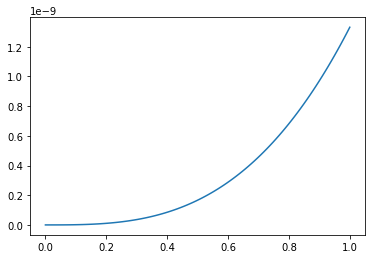

In [75]:
f = lambda ndim, step_size, gamma, a: (2.0 * a * gamma * step_size - 3.0 + 4.0 * np.exp(-a * gamma * step_size) - np.exp(
            - 2.0 * a * gamma * step_size)) / gamma ** 2

f(32, 1e-3, 2.0, alpha)

alpha_vals = np.linspace(0, 1.0, 100)
print(np.where(f(32, 1e-3, 2.0, alpha_vals) == 0.0))
plt.plot(alpha_vals, f(32, 1e-3, 2.0, alpha_vals))

In [37]:
f(32, 1e-3, 2.0, torch.tensor(0.3185))

tensor(1.4901e-08)

In [38]:
f(32, 1e-3, 2.0, 0.3185)

4.3058612231305915e-11

In [107]:
def generate_alum_noise2(ndim: int,
                         step_size: np.float64,
                         gamma: np.float64,
                         alpha: torch.Tensor,
                         taylor: bool = False):
    # Generate the noise terms for ALUM version of underdamped Langevin.
    e_xh = torch.zeros((alpha.shape[0], ndim))
    e_vh = torch.zeros((alpha.shape[0], ndim))
    e_xah = torch.zeros((alpha.shape[0], ndim))
    
    for i, a in enumerate(alpha):
        if not taylor:
            cov_xtxt = (2.0 * gamma * step_size - 3.0 + 4.0 * np.exp(-gamma * step_size) - np.exp(
                -2.0 * gamma * step_size)) / gamma ** 2
            cov_xtvt = (4.0 * np.sinh(gamma * step_size / 2.0) ** 2 * np.exp(-gamma * step_size)) / gamma
            cov_vtvt = (1.0 - np.exp(-2.0 * gamma * step_size))
            cov_xtxat = (2.0 * a * gamma * step_size - 2.0 - 4.0 * np.exp(-gamma * step_size) * np.sinh(
                a * gamma * step_size / 2.0) ** 2 + 2.0 * np.exp(-a * gamma * step_size)) / gamma ** 2
            cov_vtxat = 4.0 * np.sinh(a * gamma * step_size / 2.0) ** 2 * np.exp(
                -gamma * step_size) / gamma
            cov_xatxat = (2.0 * a * gamma * step_size - 3.0 + 4.0 * np.exp(-a * gamma * step_size) - np.exp(
                - 2.0 * a * gamma * step_size)) / gamma ** 2
        elif taylor:
            cov_xtxt = 2.0 * (gamma * step_size) ** 3 / 3.0
            cov_xtvt = gamma * step_size ** 2 * (1.0 - gamma * step_size)
            cov_vtvt = 2.0 * gamma * step_size * (1.0 - gamma * step_size + 2.0 * (gamma * step_size) ** 2 / 3.0)
            cov_xtxat = a ** 2 * gamma * step_size ** 3 * (1.0 - a / 3.0)
            cov_vtxat = a ** 2 * gamma * step_size ** 2 * (1.0 - gamma * step_size)
            cov_xatxat = 2.0 * (a * gamma * step_size) ** 3 / 3.0
        print(f'cov_xtxt = {cov_xtxt}')
        print(f'cov_xtvt = {cov_xtvt}')
        print(f'cov_vtvt = {cov_vtvt}')
        print(f'cov_xtxat = {cov_xtxat}')
        print(f'cov_vtxat = {cov_vtxat}')
        print(f'cov_xatxat = {cov_xatxat}')
        
        if cov_xatxat <= 0:
            print(f'2.0 * a * gamma * step_size = {2.0 * a * gamma * step_size}')
            print(f'4.0 * np.exp(-a * gamma * step_size) = {4.0 * np.exp(-a * gamma * step_size)}')
            print(f'np.exp(- 2.0 * a * gamma * step_size) = {np.exp(- 2.0 * a * gamma * step_size)}')
        
        cov_alum = torch.tensor([[cov_xtxt, cov_xtvt, cov_xtxat],
                                 [cov_xtvt, cov_vtvt, cov_vtxat],
                                 [cov_xtxat, cov_vtxat, cov_xatxat]], dtype=torch.float32)

        noise_vec = torch.distributions.MultivariateNormal(loc=torch.zeros(cov_alum.shape[0]),
                                                           covariance_matrix=cov_alum).sample((ndim,)).squeeze()
        e_xh[i, :] = noise_vec[:, 0]
        e_vh[i, :] = noise_vec[:, 1]
        e_xah[i, :] = noise_vec[:, 2]

    return e_xh, e_vh, e_xah

In [101]:
alpha = np.random.uniform(low=0, high=1, size=(100,))
e_xh2, e_vh2, e_xah2 = generate_alum_noise2(32, 1e-3, 2.0, alpha)
print(e_xh2.shape)

cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.72210423277886e-10
cov_vtxat = 1.3359044721975642e-06
cov_xatxat = 7.291665327091579e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 2.0544849155257339e-10
cov_vtxat = 2.3155947346883664e-07
cov_xatxat = 5.265848868063472e-11
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 4.384698160109224e-11
cov_vtxat = 4.614421522558399e-08
cov_xatxat = 4.685696275430473e-12
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.069351381008062e-10
cov_vtxat = 1.227039538989728e-06
cov_xatxat = 6.419093034892853e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.312959765000016e-10
cov_vtxat = 1.1046756040993724e-06
cov_xatxat = 5.4835788

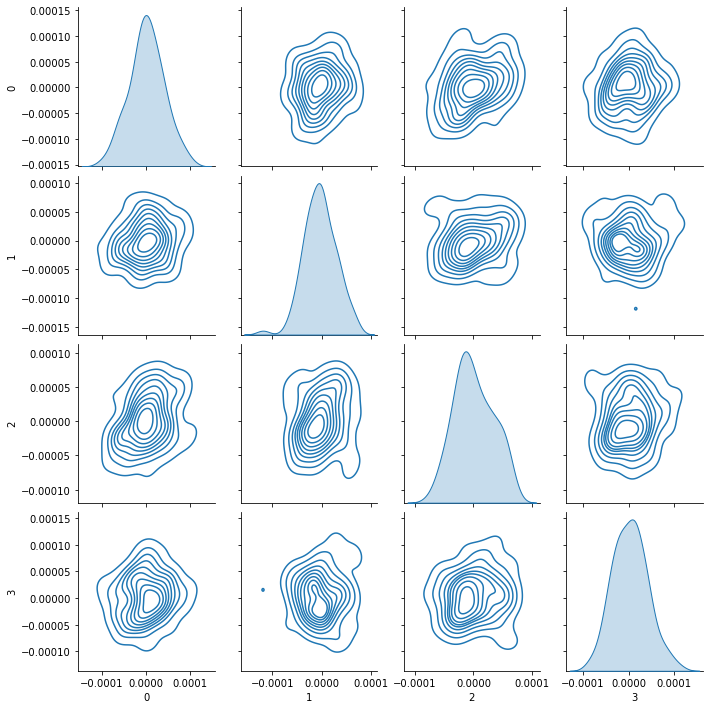

In [93]:
sns.pairplot(pd.DataFrame(e_xh2[:, 0:4].numpy()), kind='kde')

In [98]:
alpha = np.random.uniform(low=0, high=1, size=(100,))
alpha = torch.tensor(alpha, dtype=torch.float64)
e_xh, e_vh, e_xah = generate_alum_noise(32, 1.0e-3, 2.0, alpha)

cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 9.528422495463928e-10
cov_vtxat = 1.3032785915374374e-06
cov_xatxat = 7.026289827738452e-10
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 1.185916420620714e-09
cov_vtxat = 1.7153007279019394e-06
cov_xatxat = 1.0607255629402346e-09
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 2.5653257296198717e-11
cov_vtxat = 2.6655470233987012e-08
cov_xatxat = 2.057326531357262e-12
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.748740620845297e-11
cov_vtxat = 9.423165323076076e-08
cov_xatxat = 1.3672563081712497e-11
cov_xtxt = 1.3313352087429564e-09
cov_xtvt = 1.996004662669421e-06
cov_vtvt = 0.003992010656008516
cov_xtxat = 8.293569164763426e-10
cov_vtxat = 1.1015905620390375e-06
cov_xatxat = 5.460

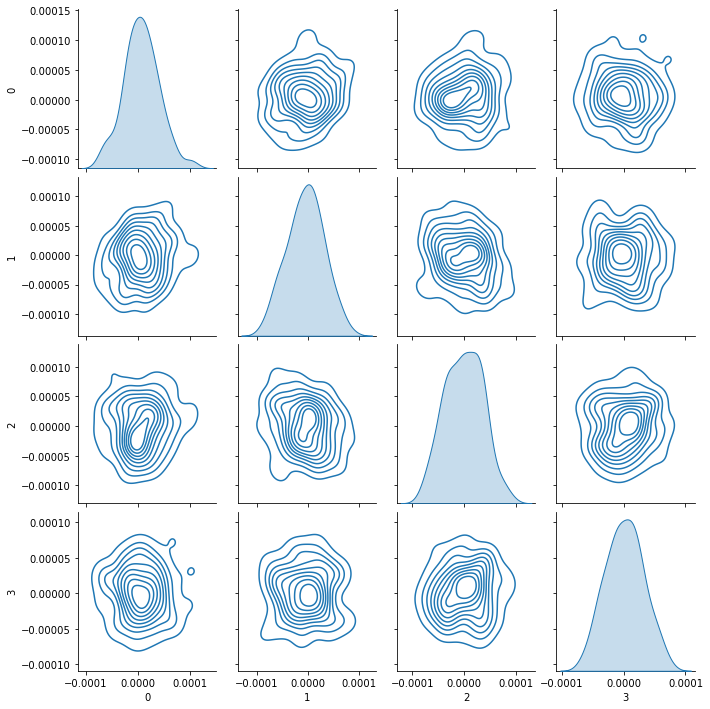

In [99]:
sns.pairplot(pd.DataFrame(e_xh[:, 0:4].numpy()), kind='kde')

    labels     $x_0$         $x_1$         $x_2$         $x_3$
0        q -0.000041  1.930139e-06  1.543943e-05  2.320784e-05
1        q -0.000054 -4.461500e-06  2.935514e-05  4.020344e-06
2        q  0.000001 -3.273755e-07  4.520668e-09 -3.533919e-07
3        q -0.000004 -9.435558e-07  6.705373e-07  8.064995e-07
4        q  0.000020 -1.067190e-05 -2.845234e-06  1.231867e-05
..     ...       ...           ...           ...           ...
195      T -0.000006 -3.578503e-06 -5.043788e-06 -5.145952e-06
196      T  0.000016 -2.328139e-05 -4.242879e-05  1.805111e-05
197      T -0.000014 -1.306053e-05  1.271722e-05  1.802192e-05
198      T -0.000001 -3.198136e-06 -3.655255e-06 -8.626909e-06
199      T -0.000005 -1.981012e-06  1.716293e-07  2.107354e-06

[200 rows x 5 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

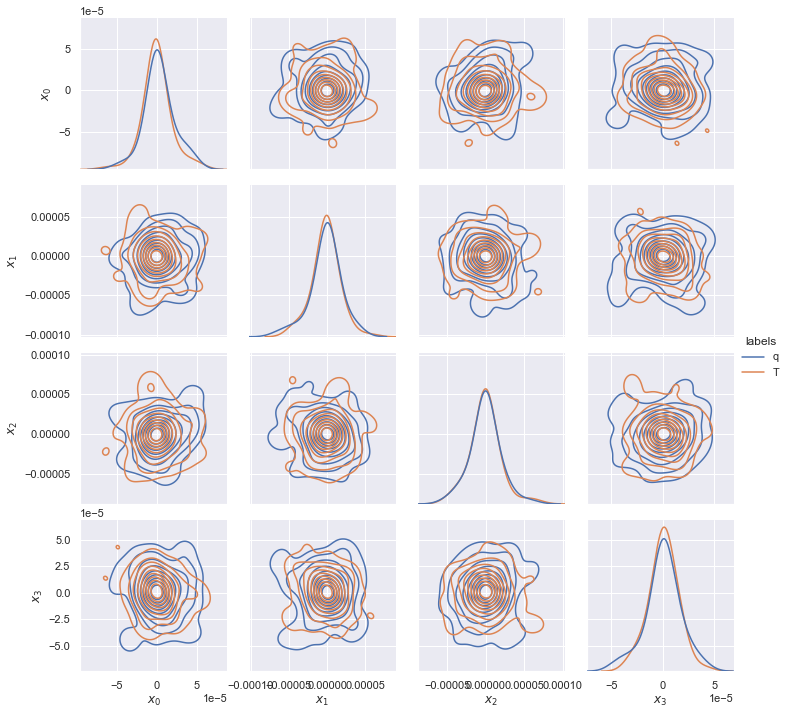

In [106]:
sns_pairplot(e_xah[:, 0:4], np.ones(len(e_xh)), e_xah2[:, 0:4])

In [108]:
te_xh2, te_vh2, te_xah2 = generate_alum_noise2(32, 1e-3, 2.0, alpha, taylor=True)

cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 9.73547788068888e-10
cov_vtxat = 1.3359014987886357e-06
cov_xatxat = 2.9202469442555967e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 2.056803377869998e-10
cov_vtxat = 2.315590007774301e-07
cov_xatxat = 2.1074167267338132e-10
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 4.389321671081102e-11
cov_vtxat = 4.6144122458418756e-08
cov_xatxat = 1.8747031511257384e-11
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 9.081635583185514e-10
cov_vtxat = 1.227036830196626e-06
cov_xatxat = 2.5706581081740418e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e-06
cov_vtvt = 0.003992010666666667
cov_xtxat = 8.32401937217332e-10
cov_vtxat = 1.1046731880087451e-06
cov_xatxat = 2.195880197722229e-09
cov_xtxt = 5.333333333333334e-09
cov_xtvt = 1.996e

    labels     $x_0$     $x_1$     $x_2$     $x_3$
0        q  0.046296  0.098652  0.083101  0.025477
1        q -0.057289 -0.037674 -0.005685  0.033873
2        q  0.160883  0.080169  0.006064 -0.038378
3        q -0.029040  0.045831  0.048976  0.059197
4        q  0.058131 -0.037097 -0.002977  0.000303
..     ...       ...       ...       ...       ...
195      T -0.118399 -0.041020 -0.133668 -0.117960
196      T  0.089511 -0.072090 -0.065181  0.109019
197      T -0.128541 -0.004776  0.030482  0.014055
198      T -0.126198  0.016780 -0.049618 -0.095654
199      T  0.010822 -0.000789 -0.007617  0.104492

[200 rows x 5 columns]


/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/ho

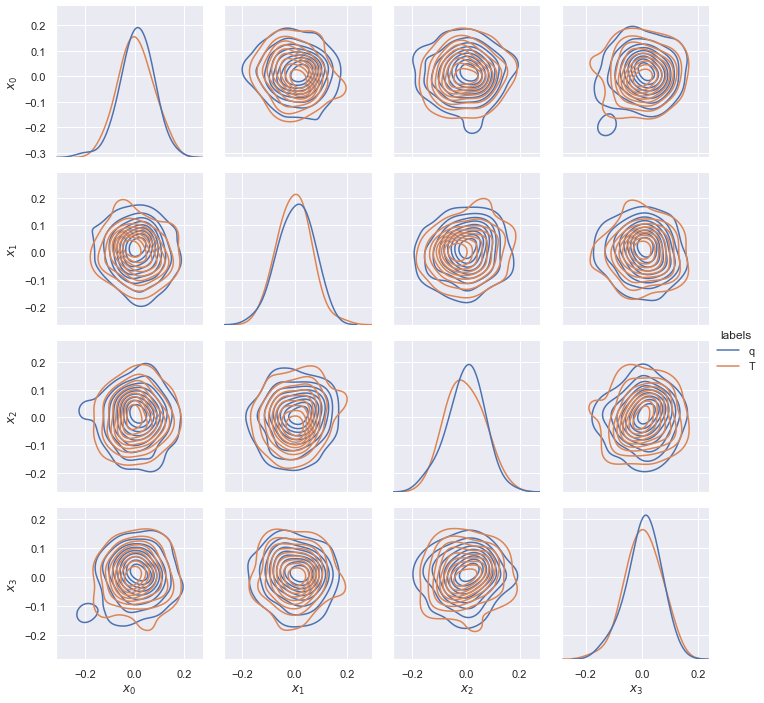

In [111]:
sns_pairplot(te_vh2[:, 0:4], np.ones(len(e_xh)), e_vh2[:, 0:4])